# Identifying PII in Student Essays
## Project Summary
The Kaggle Competition we are participating in is the [PII Data Detection hosted by The Learning Agency Lab](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/overview). The goal of this competition is to develop a model that detects sensitive personally identifiable information (PII) in student writing. This is necessary to screen and clean educational data so that when released to the public for analysis and archival, the students' risk are mitigated.

## Cloning Repo
Because one of the files is larger than 100MiB, the file could not be uploaded directly to the github repo. The solution found was using git large file system to hold the file and upload the git lfs pointer file in the place of the json.

Git Bash Code:
```
# install git lfs
git lfs install

# start file tracking for git lfs in the repo
git lfs track "*.json"

# stage/commit/push training json
git add train.json
git commit -m "add train.json"
git push
```
After cloning the repo locally, it clones the git lfs pointer file not the data file.

Git Bash Code:
```
# pull file from git lfs system into local repo using any pointer files
git lfs pull
```

Downloading Model Requires:
```git lfs track "*.safetensors"```
to clone model from github

And to use spacy pipeline: 
```
python -m spacy download en_core_web_sm
```

## External Data Sources

* [Persuade PII Dataset](https://www.kaggle.com/datasets/thedrcat/persuade-pii-dataset?rvi=1)
  * Essays from Persuade corpus, modified with synthetic PII data and corresponding labels. It was filtered for essays that contain tokens that are relevant to competition.

* [PII | External Dataset](https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset?rvi=1)
  * This is an LLM-generated external dataset that contains generated texts with their corresponding annotated labels in the required competition format.

* [NEW DATASET PII Data Detection](https://www.kaggle.com/datasets/cristaliss/new-dataset-pii-data-detection?rvi=1)
  * This dataset is a modified version of the official training which have the following changes: Revamped Labels, Token Transformation, and Token indexing

* [PII Detection Dataset (GPT)](https://www.kaggle.com/datasets/pjmathematician/pii-detection-dataset-gpt)
  * Personal data was created using python Faker package, which was then fed into the LLM to write an essay on. Overall, it contains 2000 gpt - generated essays and corresponding competition entities used in the essay.

* [AI4privacy-PII](https://www.kaggle.com/datasets/verracodeguacas/ai4privacy-pii)
  * The dataset is crafted using proprietary algorithms, ensuring the creation of synthetic data that avoids privacy violations. The data is meticulously curated with human-in-the-loop validation, ensuring both relevance and quality. It serves a crucial role in addressing the growing concerns around personal data security in AI applications.



# First Look

## Python Libraries


In [1]:
# !python -m pip install --upgrade pip
!pip install -U accelerate


import pandas as pd
import numpy as np
import spacy as sp
import re
import json
import math
from pathlib import Path
from datasets import Dataset
import os
import torch
import torch.nn as nn
from torch import cuda

import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.font_manager import FontProperties

!pip install evaluate
!pip install seqeval
import evaluate

from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification

import warnings
warnings.filterwarnings('ignore')

## Config

This section does initial configuration, loading our the bert pretained model that we use, as well as setting up hyper parameters like `EPOCHS` and `LEARNING_RATE`

In [47]:
class Config():
    def __init__(self, platform, model_name, pretrained_model_name):
        # platform = 'Kaggle'# 
        if platform == 'kaggle':
            pretrained_model_loc = '/kaggle/input/huggingface-bert/' + pretrained_model_name
            data_path = "/kaggle/input/pii-detection-removal-from-educational-data/train.json"
            model_path = '/kaggle/working/models/' + model_name +'.bin'
            submission_path = '../submission/'+ model_name + '-submission.csv'

        elif platform == 'local':
            pretrained_model_loc = pretrained_model_name
            model_path = '../models/bert_models/' + model_name +'.bin'
            data_path = "../Datasets/Official/train.json"
            submission_path = '../models/submission/'+ model_name + '-submission.csv'
# Commented out parameters are defunct
        self.config = {
            'MAX_LEN': 100,
            'TRAIN_BATCH_SIZE': 4,
            'VALID_BATCH_SIZE': 2,
            'EPOCHS': 5,
            'LEARNING_RATE':1e-5,
            # 'MAX_GRAD_NORM': 10,
            'device': 'cuda' if cuda.is_available() else 'cpu',
            'data_path': data_path,
            'model_path': model_path,
            'pretrained_model': BertForTokenClassification.from_pretrained(pretrained_model_loc, num_labels = 13),
            'tokenizer': BertTokenizerFast.from_pretrained(pretrained_model_loc),
            # 'threshold': 0.9,
            'return_entity_level_metrics': True,
            'ignore_subwords': True,
            'subm_path': submission_path
        }

In [48]:
platform = 'local'
pretrainend_model_name = 'bert-base-cased'
model_num = 1
model_name = 'model-' + str(model_num) + '-' + pretrainend_model_name

config = Config(platform,model_name, pretrainend_model_name).config

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading Datasets


### Official training data

Only load into notebook after pulling from git LFS (see above)

In [4]:
df = pd.read_json(config['data_path'])
df

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## Exploration

### Length of Essays

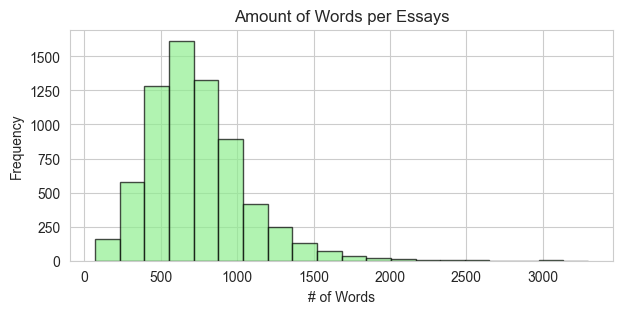

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))

plt.title('Amount of Words per Essays')
ax.hist(df['tokens'].apply(len), bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
ax.set_ylabel('Frequency')
ax.set_xlabel('# of Words')

plt.show()

### Proportion of PII as a percentage of number of words

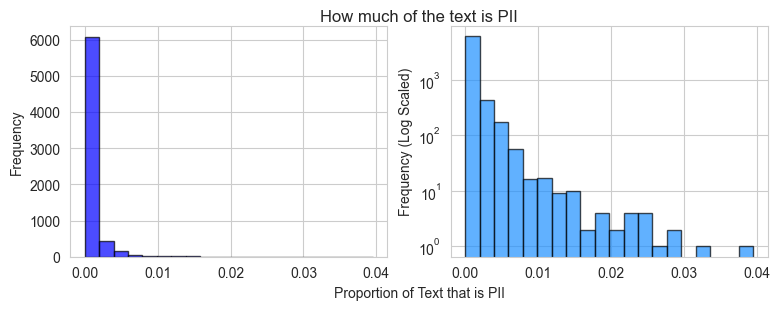

In [6]:
labels = df['labels']

non_o_values = df.apply(lambda line: sum(1 for x in line['labels'] if x != 'O') / len(line['labels']), axis = 1)
proportions_array = np.array(non_o_values)

fig, axs = plt.subplots(1,2, figsize=(9, 3))

axs[0].hist(proportions_array, bins=20, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Proportion of Text that is PII', x=1.1,y=-1)
axs[0].set_ylabel('Frequency')

axs[1].hist(proportions_array, bins=20, color='dodgerblue', edgecolor='black', alpha=0.7)
# axs[0].xlabel('Proportion of Text that is PII')
axs[1].set_yscale('log')
axs[1].set_ylabel('Frequency (Log Scaled)')

axs[0].set_title('How much of the text is PII', x=1.1,y=1.05,pad=-5)
plt.show()

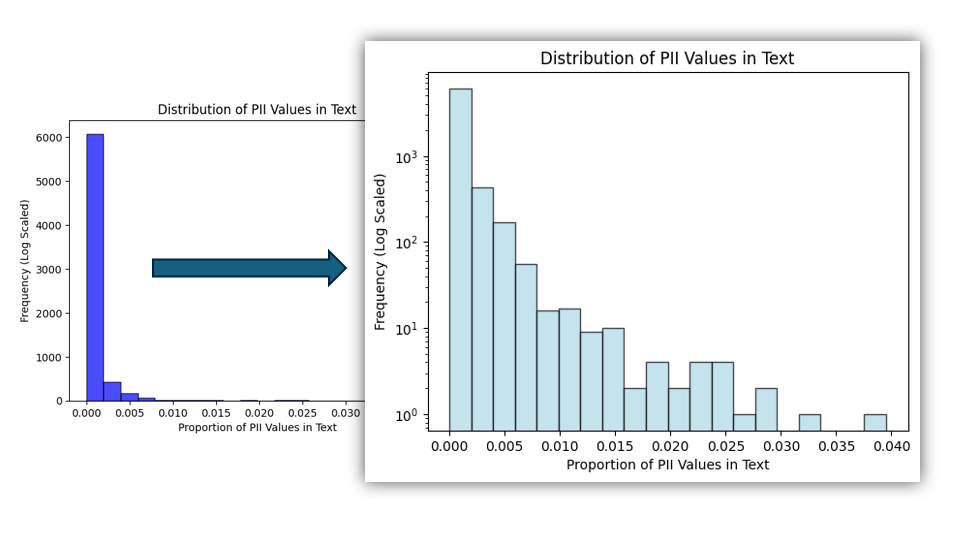

#### Hypothesis 1
Our claim is that there is at least 1 PII in each essay. We will use a t-test to evaluate this claim.

$H_0: μ_{PII}  = 0$

$H_a: μ_{PII}  > 0$

In [7]:
non_o_values1 = df.apply(lambda line: sum(1 for x in line['labels'] if x != 'O'), axis = 1)

t_statistic1, p_value1 = stats.ttest_1samp(non_o_values1, 0, alternative = 'greater')

print("t-statistic:", t_statistic1)
print("p-value:", p_value1)

t-statistic: 23.503261414082406
p-value: 8.178457800448455e-118


**Conclusion:**

Since the p-value < 0.0001 we reject $H_0$ and support the claim that there is at least 1 PII in each essay.

### Proprtion of each type of PII

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


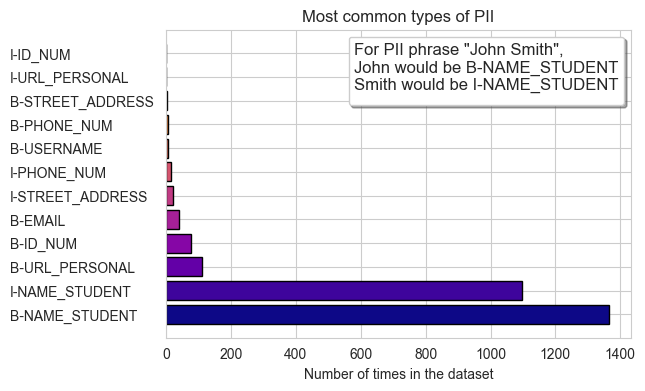

In [8]:
color_map = colormaps['plasma'].resampled(12)
color_map.colors

c = Counter()
df.apply(lambda line: c.update(line.labels), axis = 1)
c_pii = c.most_common()[1:]
c_key, c_val = zip(*c_pii)

fig, ax = plt.subplots(figsize=(6,4))
plt.barh(c_key, c_val, color=color_map.colors, edgecolor='black')

ax.set_yticklabels(c_key,ha = 'left')
plt.xlabel('Number of times in the dataset')
plt.title('Most common types of PII')
yax = ax.get_yaxis()
pad = max(T.label1.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad-35)
plt.legend(title='For PII phrase "John Smith",\nJohn would be B-NAME_STUDENT\nSmith would be I-NAME_STUDENT', title_fontsize='large', shadow=True, loc='upper right')
plt.show()

#### Hypothesis 2
Our claim is that names have a different likelihood to appear over the other PII.
To evaluate this claim, we will use a Tukey test.

$H_0: μ_{Names} = μ_{URL} = μ_{ID} = μ_{Email} = μ_{Address} = μ_{Phone} = μ_{Username}$

$H_a:  μ_{Names} \not=$ the others

In [9]:
def line_pii_cumulative(line):
    """Accumulate all of the pii in each line
    """
    c_line = Counter()
    c_line.update(line)
    c__line_pii = c_line.most_common()[1:]

    c_line_pii_cumulative = {'NAME': 0, 'URL': 0, 'ID': 0, 'EMAIL': 0, 'ADDRESS': 0, 'PHONE': 0, 'USERNAME': 0}

    for k,v in c__line_pii:
        if 'NAME_' in k:
            c_line_pii_cumulative['NAME'] += v
        elif 'URL' in k:
            c_line_pii_cumulative['URL'] += v
        elif 'ID' in k:
            c_line_pii_cumulative['ID'] += v
        elif 'EMAIL' in k:
            c_line_pii_cumulative['EMAIL'] += v
        elif 'ADDRESS' in k:
            c_line_pii_cumulative['ADDRESS'] += v
        elif 'PHONE' in k:
            c_line_pii_cumulative['PHONE'] += v
        elif 'USERNAME' in k:
            c_line_pii_cumulative['USERNAME'] += v
    return c_line_pii_cumulative


In [10]:
high_level_pii = ['NAME', 'URL', 'ID', 'EMAIL', 'ADDRESS', 'PHONE', 'USERNAME']

df1 = pd.DataFrame(data = df['labels'].apply(lambda line: line_pii_cumulative(line)).values)
df1 = pd.concat([df1.drop([0], axis = 1), df1[0].apply(pd.Series)], axis=1)

In [11]:
pvalues = stats.tukey_hsd(df1['NAME'], df1['URL'], df1['ID'], df1['EMAIL'], df1['ADDRESS'], df1['PHONE'], df1['PHONE']).pvalue

pd.options.display.float_format = '{:20,.5f}'.format
tukey_res = pd.DataFrame(pvalues < 0.0001, columns = high_level_pii, index = high_level_pii)
tukey_res[tukey_res].fillna('')

,NAME,URL,ID,EMAIL,ADDRESS,PHONE,USERNAME
NAME,,True,True,True,True,True,True
URL,True,,,,,,
ID,True,,,,,,
EMAIL,True,,,,,,
ADDRESS,True,,,,,,
PHONE,True,,,,,,
USERNAME,True,,,,,,


Where there is a True in the table above, the relationship between that column and row is that they are likely to have different average numbers of PII.

This means we can reject $H_0$ and support the claim that Name PII has a different likelihood of appearing.

Furthermore, because we have shown it is different, and we have visualized that the # of Name PII is larger than the others, we can conclude that Name PII is more likely to appear with an alpha of 0.0001.

### Positional distribution of most popular PII

In [12]:
def count_pii_in_sections(line):
    positions = {
        'Section 1': lambda x: x[:len(x)//5],
        'Section 2': lambda x: x[len(x)//5:2*(len(x)//5)],
        'Section 3': lambda x: x[2*(len(x)//5):3*(len(x)//5)],
        'Section 4': lambda x: x[3*(len(x)//5):-(len(x)//5)],
        'Section 5': lambda x: x[-(len(x)//5):-1],
    }
    label_counts_PII = {pos: 0 for pos in positions}

    for pos, func in positions.items():
        temp_arr = func(line)
        for label in temp_arr:
            if label != 'O':
                label_counts_PII[pos] += 1
    return label_counts_PII

In [13]:
locations = ['Section 1', 'Section 2', 'Section 3', 'Section 4', 'Section 5']

df2 = pd.DataFrame(data = df['labels'].apply(lambda line: count_pii_in_sections(line)).values)
df2 = pd.concat([df2.drop([0], axis = 1), df2[0].apply(pd.Series)], axis=1)
df3 = df2.apply(sum)

Text(0.5, 0, 'Divisions of Text')

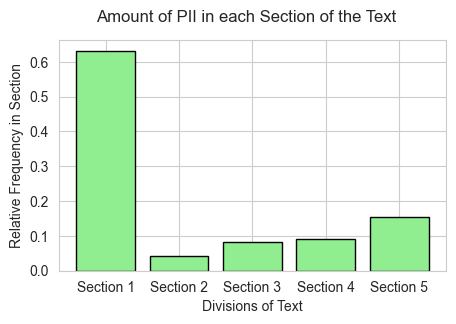

In [14]:
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df3.index, df3/sum(df3), color='lightgreen', edgecolor='black')
plt.suptitle('Amount of PII in each Section of the Text')
# plt.yticks(ax.get_yticks()))
plt.ylabel('Relative Frequency in Section')
plt.xlabel('Divisions of Text')

#### Hypothesis 3

Our claim is that PII has a different likelihood to appear in section 1 over the other sections.
To evaluate this claim, we will use a Tukey test.

$H_0: μ_1 = μ_2 = μ_3 = μ_4 = μ_5$

$H_a: μ_1 \not=$ the others

In [15]:
pvalues = stats.tukey_hsd(df2['Section 1'],df2['Section 2'],df2['Section 3'],df2['Section 4'],df2['Section 5']).pvalue

pd.options.display.float_format = '{:20,.5f}'.format
tukey_res = pd.DataFrame(pvalues < 0.0001, columns = locations, index = locations)
tukey_res[tukey_res].fillna('')

,Section 1,Section 2,Section 3,Section 4,Section 5
Section 1,,True,True,True,True
Section 2,True,,,,True
Section 3,True,,,,
Section 4,True,,,,
Section 5,True,True,,,


Where there is a True in the table above, the relationship between that column and row is that they are likely to have different average numbers of PII.

This means that the PII found in sections 2,3,4 and 5. As well as that section 2 has a different average number of PII than the number of PII found in section 5.

This means we can reject  H0  and support the claim that PII is has a different likelihood of appearing in section 1.

Furthermore, because we have shown it is different, and we have visualized that the # of PII in section one is larger than the others, we can conclude that PII is more likely to appear in section 1 with an alpha of 0.0001

# Preparing Model Inputs

## Cleaning

First we scoured the data to find the usuable text with our pretrained model with Regex.

In [16]:
pattern_space = re.compile('\xa0|\uf0b7|\u200b')
df.loc[:,'full_text'] = df.loc[:,'full_text'].replace(pattern_space, ' ')
df.loc[:,'tokens'] = df.loc[:,'tokens'].apply(lambda line: [tok for tok in line if not re.search(pattern_space,tok)])
# [,.!?-]
df_usable = df.iloc[df[~(df.tokens.apply(len) != df.labels.apply(len))].index]
1-(len(df_usable))/len(df.document)

0.06184809754664311

In [17]:
df_usable.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


## Preprocessing

Label mapping

In [18]:
labels_to_ids = {k: v for v, k in enumerate(c.keys())}
ids_to_labels = {v: k for v, k in enumerate(c.keys())}
labels_to_ids

{'O': 0,
 'B-NAME_STUDENT': 1,
 'I-NAME_STUDENT': 2,
 'B-URL_PERSONAL': 3,
 'B-EMAIL': 4,
 'B-ID_NUM': 5,
 'I-URL_PERSONAL': 6,
 'B-USERNAME': 7,
 'B-PHONE_NUM': 8,
 'I-PHONE_NUM': 9,
 'B-STREET_ADDRESS': 10,
 'I-STREET_ADDRESS': 11,
 'I-ID_NUM': 12}

We created a function to tokenize and label all of the lines in the dataset.

In [19]:
def make_smaller_inputs(dataframe):
    df_out = pd.DataFrame(columns = ['tokens','labels','document','document_location'])
    idx_df = 0
    max_len = config['MAX_LEN']
    
    for _,line in dataframe.iterrows():
        location_counter = 0
        tokens = line.tokens
        labels = line.labels
        document = line.document
        items = range(0,len(tokens),max_len)
        
        for i in items:
            df_out.at[idx_df,'tokens'] = tokens[i:i+max_len]
            df_out.at[idx_df,'labels'] = labels[i:i+max_len]
            df_out.at[idx_df,'document'] = document
            df_out.at[idx_df,'document_location'] = location_counter
            location_counter += 1
            idx_df += 1
        
    return df_out

In [20]:
df_model_input = make_smaller_inputs(df_usable)
print(len(df_model_input.index))
df_model_input.head(2)

49199


,tokens,labels,document,document_location
0,"[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...",7,0
1,"['s, , potential, to, be, released, ., Cf, An...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",7,1


Removing rows with only "O" labels

In [21]:
def compare2dict(list1, list2, pii_threshold):
    return len(set(list1).intersection(set(list2))) > 1

In [22]:
df_trainable = df_model_input[df_model_input.apply(lambda line: compare2dict(line.labels,list(labels_to_ids.keys()),0), axis = 1)]
df_trainable_input = pd.concat([df_trainable] * 10).sample(frac=1)
df_trainable_input.reset_index(drop = True, inplace=True)
print(len(df_trainable_input))
df_trainable_input.head(2)

11560


,tokens,labels,document,document_location
0,"[most, appropriate, one, for, this, case, ., I...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",9050,1
1,"[Reflection, -, Visualization, \n\n, (, Email,...","[O, O, O, O, O, O, O, O, O, O, B-NAME_STUDENT,...",12956,0


In [ ]:
df_evaluation_input = df_model_input[['tokens','labels']]
df_evaluation_input.head(2)

In [23]:
df_prediction_input = df_model_input[['tokens','document','document_location']]
df_prediction_input.head(2)

,tokens,document,document_location
0,"[Design, Thinking, for, innovation, reflexion,...",7,0
1,"['s, , potential, to, be, released, ., Cf, An...",7,1


df_trainable_input will be for training
df_prediction_input will be for predicting

### Creating the training and testing split

In [24]:
# df_train, df_test = train_test_split(df_trainable, test_size=0.3)

### Formatting split

In [25]:
# df_train.reset_index(drop = True, inplace=True)
# df_train

In [26]:
# df_test.reset_index(drop = True, inplace=True)
# df_test

# Model


## Iteration 1

adapted from 
https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Custom_Named_Entity_Recognition_with_BERT_only_first_wordpiece.ipynb#scrollTo=Eh3ckSO0YMZW

### Tokenizer and Label allignment

In [27]:
# class dataset(Dataset):
#     def __init__(self, dataframe, tokenizer, max_len):
#         self.len = len(dataframe)
#         self.data = dataframe
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __getitem__(self, index):
#         # step 1: get the sentence and word labels 
#         tokens = self.data.tokens[index]
#         word_labels = self.data.labels[index]

#         # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
#         # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
#         encoding = self.tokenizer(tokens,
#                                   is_split_into_words=True,
#                                   return_offsets_mapping=True,
#                                   padding='max_length',
#                                   truncation=True,
#                                   max_length=self.max_len)

#         # step 3: create token labels only for first word pieces of each tokenized word
#         labels = [ labels_to_ids[label] for label in word_labels]
#         # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
#         # create an empty array of -100 of length max_length
#         encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

#         # set only labels whose first offset position is 0 and the second is not 0
#         i = 0
#         for idx, mapping in enumerate(encoding["offset_mapping"]):
#             if mapping[0] == 0 and mapping[1] != 0:
#                 # overwrite label
#                 encoded_labels[idx] = labels[i]
#                 i += 1

#         # step 4: turn everything into PyTorch tensors
#         item = {key: torch.as_tensor(val) for key, val in encoding.items()}
#         item['labels'] = torch.as_tensor(encoded_labels)

#         return item

#     def __len__(self):
#         return self.len
# training_set = dataset(df_train, config['tokenizer'], config['MAX_LEN'])
# testing_set = dataset(df_test, config['tokenizer'], config['MAX_LEN'])
# training_set[2]["input_ids"].unsqueeze(0)
# for token, label in zip(config['tokenizer'].convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
#     print('{0:10}  {1}'.format(token, label))

Setting training and testing parameters

In [28]:
# train_params = {'batch_size': config["TRAIN_BATCH_SIZE"],
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# test_params = {'batch_size': config["VALID_BATCH_SIZE"],
#                'shuffle': True,
#                'num_workers': 0
#                }

# training_loader = DataLoader(training_set, **train_params)
# testing_loader = DataLoader(testing_set, **test_params)
# model = BertForTokenClassification.from_pretrained(config['pretrained_model'], num_labels=len(labels_to_ids))
# model.to(config['device'])
# optimizer = torch.optim.Adam(params=model.parameters(), lr=config['LEARNING_RATE'])

### Training

In [29]:
### Training
# # Defining the training function on the 80% of the dataset for tuning the bert model
# def train(epoch):
#     tr_loss, tr_accuracy = 0, 0
#     nb_tr_examples, nb_tr_steps = 0, 0
#     tr_preds, tr_labels = [], []
#     # put model in training mode
#     model.train()
# 
#     for idx, batch in enumerate(training_loader):
# 
#         ids = batch['input_ids'].to(config['device'], dtype = torch.long)
#         mask = batch['attention_mask'].to(config['device'], dtype = torch.long)
#         labels = batch['labels'].to(config['device'], dtype = torch.long)
# 
#         outputs = model(input_ids=ids.long(), attention_mask=mask.long(), labels=labels.long())
#         loss = outputs[0]
#         tr_logits = outputs[1]
#         tr_loss += loss.item()
# 
#         nb_tr_steps += 1
#         nb_tr_examples += labels.size(0)
# 
#         if idx % 100==0:
#             loss_step = tr_loss/nb_tr_steps
#             print(f"Training loss per 100 training steps: {loss_step}")
# 
#         # compute training accuracy
#         flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
#         active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
#         flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
#         
#         # only compute accuracy at active labels
#         active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
#         #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
# 
#         labels = torch.masked_select(flattened_targets, active_accuracy)
#         predictions = torch.masked_select(flattened_predictions, active_accuracy)
# 
#         tr_labels.extend(labels)
#         tr_preds.extend(predictions)
# 
#         tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
#         tr_accuracy += tmp_tr_accuracy
# 
#         # gradient clipping
#         torch.nn.utils.clip_grad_norm_(
#             parameters=model.parameters(), max_norm=config['MAX_GRAD_NORM']
#         )
# 
#         # backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# 
#     epoch_loss = tr_loss / nb_tr_steps
#     tr_accuracy = tr_accuracy / nb_tr_steps
#     print(f"Training loss epoch: {epoch_loss}")
#     print(f"Training accuracy epoch: {tr_accuracy}")
# run = False
# if run:
#     for epoch in range(config['EPOCHS']):
#         print(f"Training epoch: {epoch + 1}")
#         train(epoch)
#     run = False

Training epoch: 1
Training loss epoch: 0.007183262327166176
Training accuracy epoch: 0.9988009906964034

Execution Time: 2h 33m 45s
Batch Size: 2
LR: 1e-5
Optimizer: Adam

### Save Model

In [30]:
# import os

# directory = config['model_path']

# if not os.path.exists(directory):
#     os.makedirs(directory)

# # save vocabulary of the tokenizer
# config['tokenizer'].save_vocabulary(directory)
# # save the model weights and its configuration file
# save_model = True
# if save_model:  
#     model.save_pretrained(directory)
#     print('All files saved')

### Model Validation

In [31]:
# model_1 = BertForTokenClassification.from_pretrained(config['model_path'], num_labels=len(labels_to_ids))
# model_1.to(config['device'])
# # def valid(model, testing_loader):
#     # put model in evaluation mode
#     model.eval()
    
#     eval_loss, eval_accuracy = 0, 0
#     nb_eval_examples, nb_eval_steps = 0, 0
#     eval_preds, eval_labels = [], []
    
#     with torch.no_grad():
#         for idx, batch in enumerate(testing_loader):
            
#             ids = batch['input_ids'].to(config['device'], dtype = torch.long)
#             mask = batch['attention_mask'].to(config['device'], dtype = torch.long)
#             labels = batch['labels'].to(config['device'], dtype = torch.long)

#             outputs = model(input_ids=ids.long(), attention_mask=mask.long(), labels=labels.long())
            
#             loss = outputs[0]
#             eval_logits = outputs[1]
#             eval_loss += loss.item()
            
#             nb_eval_steps += 1
#             nb_eval_examples += labels.size(0)
        
#             if idx % 100==0:
#                 loss_step = eval_loss/nb_eval_steps
#                 print(f"Validation loss per 100 evaluation steps: {loss_step}")
            
#             # compute evaluation accuracy
#             flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
#             active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
#             flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
#             # only compute accuracy at active labels
#             active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
#             labels = torch.masked_select(flattened_targets, active_accuracy)
#             predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
#             eval_labels.extend(labels)
#             eval_preds.extend(predictions)
            
#             tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
#             eval_accuracy += tmp_eval_accuracy

#     labels = [ids_to_labels[id.item()] for id in eval_labels]
#     predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
#     eval_loss = eval_loss / nb_eval_steps
#     eval_accuracy = eval_accuracy / nb_eval_steps
#     print(f"Validation Loss: {eval_loss}")
#     print(f"Validation Accuracy: {eval_accuracy}")

#     return labels, predictions

# labels, predictions = valid(model_1, testing_loader)

Validation Loss: 0.0025191350434306515
Validation Accuracy: 0.9994422838479019
Execution Time: 08m 07.238s

In [32]:
# print(classification_report(labels, predictions))

About 50% for getting student names correct, 0% for the others

## Iteration 2

Updating the tokenizer to properly create context between the words and the PII labels

In [33]:
# def tokenize(df, tokenizer):
#     text = []
#     token_map = []
#     
#     idx = 0
#     
#     for t, ws in zip(df["tokens"], df["trailing_whitespace"]):
#         
#         text.append(t)
#         token_map.extend([idx]*len(t))
#         if ws:
#             text.append(" ")
#             token_map.append(-1)
#             
#         idx += 1
#         
#         
#     tokenized = tokenizer("".join(text), return_offsets_mapping=True, truncation=False)
#     
#         
#     return {
#         **tokenized,
#         "token_map": token_map,
#     }

### Tokenizer and Label allignment

In [34]:
def tokenize(line, tokenizer, type):
    tokens = line.tokens

    if config['ignore_subwords']:
        length = math.ceil(config['MAX_LEN'] * 1.2)
    else:
        length = config['MAX_LEN']

    encoding = tokenizer(tokens,
                         is_split_into_words= True,
                         return_offsets_mapping= True,
                         padding= 'max_length',
                         max_length= length)

    item = {key: torch.as_tensor(val) for key, val in encoding.items()}

    if type == 'train' or type == 'eval':
        word_labels = line.labels

        temp_list = [0 for _ in range(length - len(word_labels))]
        labels = [labels_to_ids[label] for label in word_labels] + temp_list

        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        i = 0

        if config['ignore_subwords']:
            #         Ignore subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0 and mapping[1] != 0:
                    # overwrite label
                    encoded_labels[idx] = labels[i]
                    i += 1
        else:
            #         Extend subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0:
                    encoded_labels[idx] = labels[i]
                    i += 1

        item['labels'] = torch.as_tensor(encoded_labels)

        return {**item}

    if type == 'predict':
        document = line.document
        location = line.document_location

        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        labels = np.zeros(len(tokens), dtype=int)
        i = 0

        if config['ignore_subwords']:
            #         Ignore subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0 and mapping[1] != 0:
                    # overwrite label
                    encoded_labels[idx] = labels[i]
                    i += 1
        else:
            #         Extend subword labels
            for idx, mapping in enumerate(encoding["offset_mapping"]):
                if mapping[0] == 0:
                    encoded_labels[idx] = labels[i]
                    i += 1
        item['labels'] = torch.as_tensor(encoded_labels)

        return {**item, 'document': document, 'location': location}

Create the mappings for the tokenized text, calling the tokenizer function above. This will store all of the values in separate lists that we will be able to call for the output function.

In [35]:
# with open("cleaned_train.json", "w") as data_file:
#     data_file.write(df_train.to_json())
#     data_file.close()

# with open("cleaned_train.json", "r") as f:
#     data = json.load(f)

# with open("../datasets/Official/train.json", "r") as f:
#   data = json.load(f)

# print(data)

# ds = Dataset.from_dict({
#     # "full_text": [x["full_text"] for x in data],
#     "labels": data["labels"],
#     "tokens": data["tokens"],
#     # "trailing_whitespace": [x["trailing_whitespace"] for x in data],
# })


# tokenizer = BertTokenizerFast.from_pretrained(config['model_path'])

In [36]:
train_dataset_temp = df_trainable_input.apply(lambda line: tokenize(line, config['tokenizer'],'train'), axis = 1).to_list()
# train_dataset_temp
# train_dataset = Dataset.from_list(pd.DataFrame(data=train_dataset_temp))

# from_list not implemented in this notebook's version of datasets, janky version of the above
train_dataset = Dataset.from_dict({k: [s[k] for s in train_dataset_temp] for k in  train_dataset_temp[0].keys()})
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'document', 'location'],
    num_rows: 11560
})

In [37]:
eval_dataset_temp = df_evaluation_input.apply(lambda line: tokenize(line, config['tokenizer'],'eval'), axis = 1)
# # eval_dataset = Dataset.from_list(eval_dataset_temp)
eval_dataset = Dataset.from_dict({k: [s[k] for s in eval_dataset_temp] for k in  eval_dataset_temp[0].keys()})
eval_dataset

In [38]:
predict_dataset_temp = df_prediction_input.apply(lambda line: tokenize(line, config['tokenizer'],'predict'), axis = 1)
# predict_dataset = Dataset.from_list(predict_dataset_temp)
predict_dataset = Dataset.from_dict({k: [s[k] for s in predict_dataset_temp] for k in  predict_dataset_temp[0].keys()})
predict_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'document', 'location'],
    num_rows: 49199
})

Create the new training class, with the model creation leveraging BertModelForTokenClassification

In [39]:
model = config['pretrained_model']
data_collator = DataCollatorForTokenClassification(config['tokenizer'])
metric = evaluate.load("seqeval")

In [40]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [ids_to_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [ids_to_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if config['return_entity_level_metrics']:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

### Training

In [41]:
torch.cuda.is_available()

True

In [42]:
training_args = TrainingArguments(
    output_dir= config['model_path'],
    overwrite_output_dir = True,
    do_train = True,
    do_predict = True,
    do_eval = True,
    per_device_eval_batch_size=conig['VALID_BATCH_SIZE'],
    per_device_train_batch_size=config['TRAIN_BATCH_SIZE'],
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    # auto_find_batch_size=True,
    report_to="none",
    num_train_epochs = config['EPOCHS'],
    learning_rate = config['LEARNING_RATE'],
    save_strategy = 'epoch',
    disable_tqdm= False,
    no_cuda = False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    # tokenizer=config['tokenizer'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Next, we call the actual training function that will supply the model created above with the information that it needs to create context between text, and the labels. It will work out which values match the closes and assign the proper label to it, based on how well that label matches the value.

https://github.com/huggingface/transformers/blob/main/examples/pytorch/token-classification/run_ner.py#L546

In [43]:
# Training
if training_args.do_train:
    train_result = trainer.train()
    metrics = train_result.metrics
    trainer.save_model()  # Saves the tokenizer too for easy upload

    # max_train_samples = (
    #     data_args.max_train_samples if data_args.max_train_samples is not None else len(train_dataset)
    # )
    metrics["train_samples"] = len(train_dataset)

    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    # trainer.save_state()

In [44]:
torch.cuda.empty_cache()
trainer.model = BertForTokenClassification.from_pretrained(config['model_path'])
trainer.model.to(config['device'])

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [45]:
# Evaluation
if training_args.do_eval:
    #     logger.info("*** Evaluate ***")

    metrics = trainer.evaluate()

    #   max_eval_samples = data_args.max_eval_samples if data_args.max_eval_samples is not None else len(eval_dataset)
    metrics["eval_samples"] = len(eval_dataset)

    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)

### Prediction

In [46]:
# Predict
if training_args.do_predict:
    # logger.info("*** Predict ***")

    predictions, labels, metrics = trainer.predict(predict_dataset, metric_key_prefix="predict")
    predictions = predictions.argmax(-1)

    # Remove ignored index (special tokens)
    true_predictions = [
        [ids_to_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # trainer.log_metrics("predict", metrics)
    # trainer.save_metrics("predict", metrics)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Create the lists, pulling the context of the list. This will look at the token_map and place the proper label in it's own list, which is associated with the index of the corresponding item in the other list.

It ensures that we are ignoring the o labels so that we don't report those in our created file.

### Build Submission

This next part is creating the submission file for Kaggle

In [ ]:
results = []
for preds, location, doc in zip(
        true_predictions,
        predict_dataset["location"],
        predict_dataset["document"]
):
    results.extend([(doc, location * config['MAX_LEN'] + idx, label) for idx, label in enumerate(preds) if label != 'O'])

In [ ]:
df_submission = pd.DataFrame(results, columns = ['Document','Token','Label'])
# df_submission['Row_ID'] = df_submission.index
df_submission_final = df_submission[['Document','Token','Label']]
df_submission_final

In [ ]:
df_submission_final.to_csv(config['subm_path'],index = True)